# Data Investigation - Status Data

### Import Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
sns.set()

In [2]:
print('Loading Status Data...')

status_01 = pd.DataFrame()
status_02 = pd.DataFrame()
status_03 = pd.DataFrame()
status_04 = pd.DataFrame()

try:
    file_path_slug = '../../../datasets/bayareabikeshare/*_status_data.csv'

    # glob all files
    file_list = glob(file_path_slug)

    status_import = pd.DataFrame()

    counter = 1
    

    # load data from each file
    for file in file_list:
        chunks = []
        # import file in chunks
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):

            # append chunk to chunks list
            chunks.append(chunk)

        if counter == 1:
            status_01 = pd.concat(chunks)
        elif counter == 2:
            status_02 = pd.concat(chunks)
        elif counter == 3:
            status_03 = pd.concat(chunks)
        elif counter == 4:
            status_04 = pd.concat(chunks)
        else:
            pass

        
        print('\tFinished file! (%d of %d)' % (counter, len(file_list)))
        counter += 1



    print('Data Loaded Successfully!')

except:
    print('oops... something went wrong importing the data :(')
    

    


Loading Status Data...
	Finished file! (1 of 4)
	Finished file! (2 of 4)
	Finished file! (3 of 4)
	Finished file! (4 of 4)
Data Loaded Successfully!


In [3]:
# status_data = status_import.copy()
# status_data.info()

In [4]:
# status_data.head()

### Clean And Resample Data

In [33]:
# convert time to datetime
status_01_copy = status_01.copy()
status_01_copy['time']   = pd.to_datetime(status_01_copy['time'],   format="%Y/%m/%d %H:%M:%S")


status_02_copy = status_02.copy()
status_02_copy['time']   = pd.to_datetime(status_02_copy['time'],   format="%Y/%m/%d %H:%M:%S")


status_03_copy = status_03.copy()
status_03_copy['time']   = pd.to_datetime(status_03_copy['time'],   format="%m/%d/%Y %H:%M:%S")


status_04_copy = status_04.copy()
status_04_copy['time']   = pd.to_datetime(status_04_copy['time'],   format="%Y/%m/%d %H:%M:%S")



In [35]:
status_02_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36647622 entries, 0 to 36647621
Data columns (total 4 columns):
station_id         int64
bikes_available    int64
docks_available    int64
time               datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 GB


In [36]:
status_time_clean = pd.concat([status_01_copy, status_02_copy, status_03_copy, status_04_copy])
status_time_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 107501619 entries, 0 to 16994601
Data columns (total 4 columns):
station_id         int64
bikes_available    int64
docks_available    int64
time               datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.0 GB


In [38]:
# append total_docks column
status_time_clean['total_docks'] = status_time_clean['bikes_available'] + status_time_clean['docks_available']
status_time_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107501619 entries, 0 to 16994601
Data columns (total 5 columns):
station_id         int64
bikes_available    int64
docks_available    int64
time               datetime64[ns]
total_docks        int64
dtypes: datetime64[ns](1), int64(4)
memory usage: 4.8 GB


In [39]:
status_time_clean.head()

,station_id,bikes_available,docks_available,time,total_docks
0,2,12,15,2014-03-01 00:00:02,27
1,2,12,15,2014-03-01 00:01:03,27
2,2,12,15,2014-03-01 00:02:03,27
3,2,12,15,2014-03-01 00:03:02,27
4,2,12,15,2014-03-01 00:04:03,27


In [40]:
# set time column as index
status_time_clean.set_index('time', inplace=True)

status_data = status_time_clean.copy()

> From Analysis of Trip Data, we can see that key commute hours for Subscribers are:
-    Morning Commute Hours 07:00-11:00
-    Evening Commute Hours 16:00-20:00

> From Analysis of Trip Data, we can see that key Stations for Subscribers are:
-    Morning Commute Stations 
    - top_am_commute_start_terms = [50, 54, 55, 61, 67, 69, 70, 73, 74, 77]
    - top_am_commute_end_terms   = [51, 55, 60, 61, 63, 65, 69, 70, 74, 77]
>
>
-    Evening Commute Stations 
    - top_pm_commute_start_terms = [55, 60, 61, 64, 65, 67, 69, 70, 74, 77]
    - top_pm_commute_end_terms   = [39, 50, 55, 60, 61, 65, 69, 70, 74, 77]
>

In [41]:
# prune only morning commute hours from subscribers [07:00 - 11:00]
am_commute_start = datetime.datetime.strptime('07:00', '%H:%M').time()
am_commute_end = datetime.datetime.strptime('11:00', '%H:%M').time()
morning_commute_status = status_data.between_time(start_time=am_commute_start,
                                                     end_time=am_commute_end,
                                                     include_start=True,
                                                     include_end=True)

morning_commute_status.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17850597 entries, 2014-03-01 07:00:03 to 2014-02-28 10:59:02
Data columns (total 4 columns):
station_id         int64
bikes_available    int64
docks_available    int64
total_docks        int64
dtypes: int64(4)
memory usage: 680.9 MB


In [42]:
# prune only evening commute hours from subscribers [16:00 - 20:00]
pm_commute_start = datetime.datetime.strptime('16:00', '%H:%M').time()
pm_commute_end = datetime.datetime.strptime('20:00', '%H:%M').time()
evening_commute_status = status_data.between_time(start_time=pm_commute_start,
                                                     end_time=pm_commute_end,
                                                     include_start=True,
                                                     include_end=True)

evening_commute_status.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17962011 entries, 2014-03-01 16:00:03 to 2014-02-28 19:59:03
Data columns (total 4 columns):
station_id         int64
bikes_available    int64
docks_available    int64
total_docks        int64
dtypes: int64(4)
memory usage: 685.2 MB


In [43]:
# prune only important stations for each commute period
top_am_commute_start_terms = [50, 54, 55, 61, 67, 69, 70, 73, 74, 77]
top_am_commute_end_terms = [51, 55, 60, 61, 63, 65, 69, 70, 74, 77]
top_pm_commute_start_terms = [55, 60, 61, 64, 65, 67, 69, 70, 74, 77]
top_pm_commute_end_terms = [39, 50, 55, 60, 61, 65, 69, 70, 74, 77]


morning_commute_status_start = morning_commute_status[morning_commute_status.station_id.isin(top_am_commute_start_terms)].copy()
morning_commute_status_end   = morning_commute_status[morning_commute_status.station_id.isin(top_am_commute_end_terms)].copy()
evening_commute_status_start = evening_commute_status[evening_commute_status.station_id.isin(top_pm_commute_start_terms)].copy()
evening_commute_status_end   = evening_commute_status[evening_commute_status.station_id.isin(top_pm_commute_end_terms)].copy()

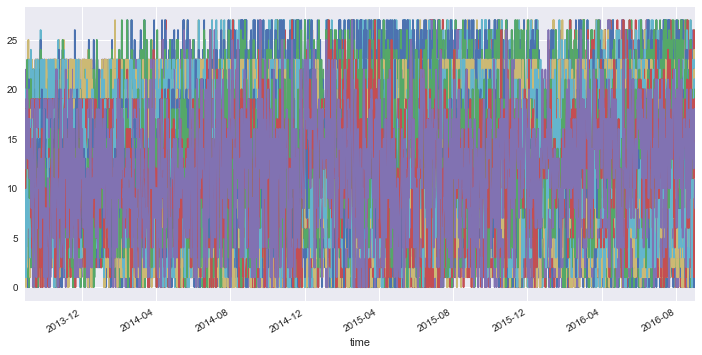

In [48]:
morning_commute_status_start.groupby(['station_id', morning_commute_status_start.index.hour])['docks_available'].plot(figsize=(12,6))
plt.show()

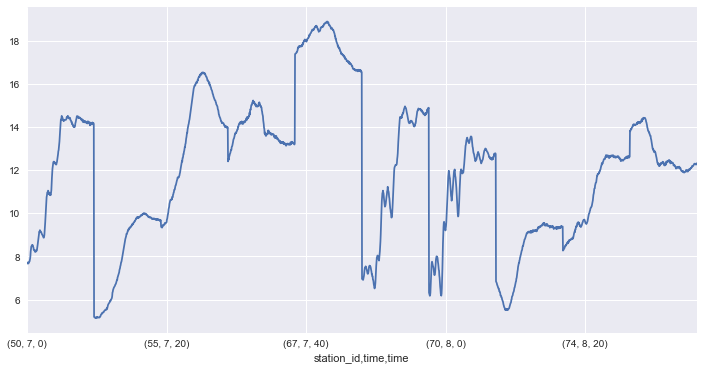

In [62]:
morning_commute_status_start.groupby(['station_id', morning_commute_status_start.index.hour, morning_commute_status_start.index.minute]).mean()['docks_available'].plot(figsize=(12,6))
plt.show()

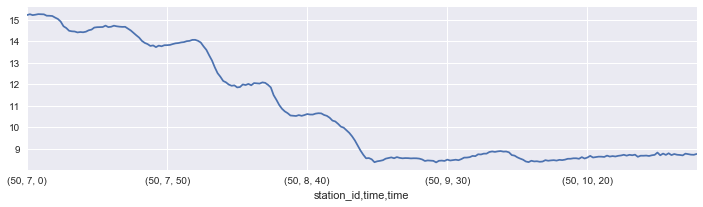

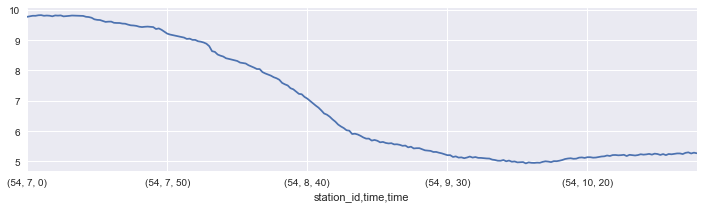

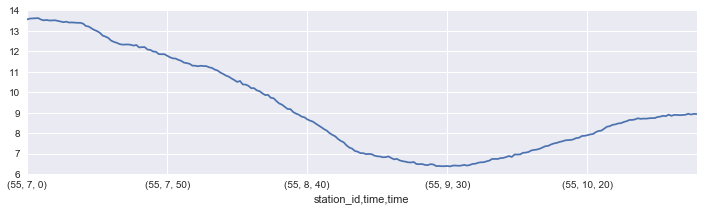

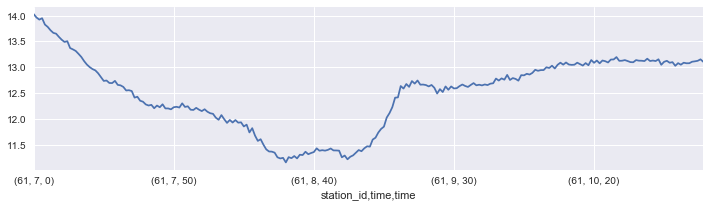

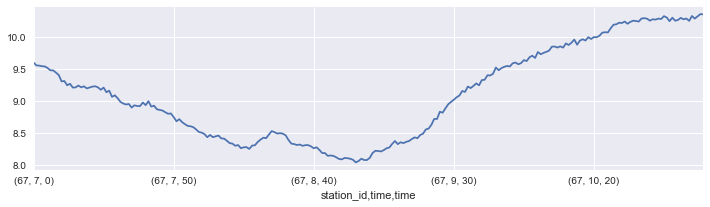

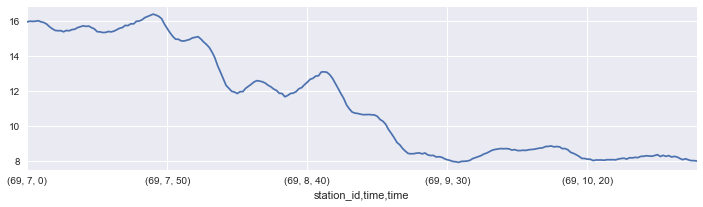

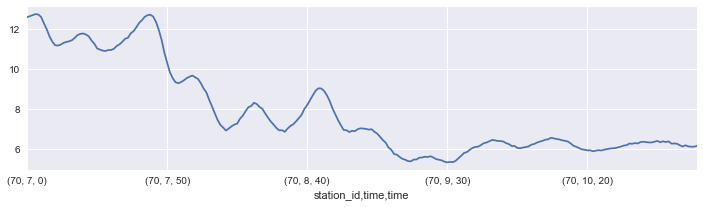

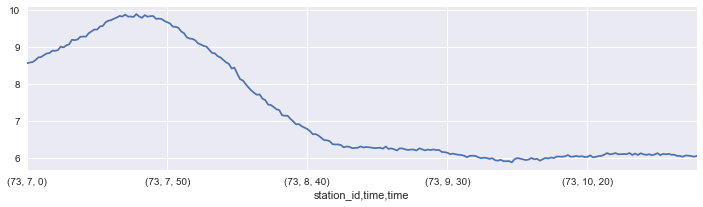

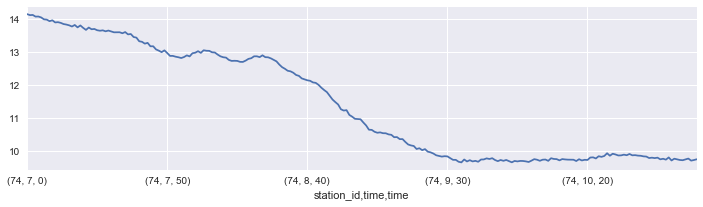

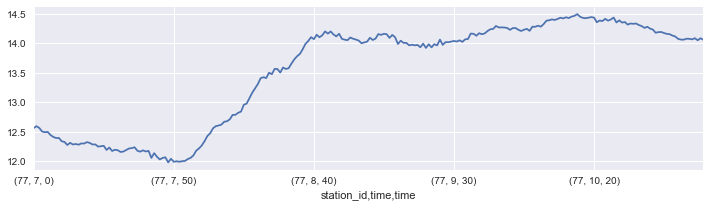

In [69]:
for i in pd.unique(morning_commute_status_start.station_id):
    data = morning_commute_status_start[morning_commute_status_start.station_id == i]
    data.groupby(['station_id', data.index.hour, data.index.minute]).mean()['bikes_available'].plot(figsize=(12,3))
    plt.show()

In [70]:
status_data.info()






<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 107501619 entries, 2014-03-01 00:00:02 to 2014-02-28 23:59:03
Data columns (total 4 columns):
station_id         int64
bikes_available    int64
docks_available    int64
total_docks        int64
dtypes: int64(4)
memory usage: 4.0 GB


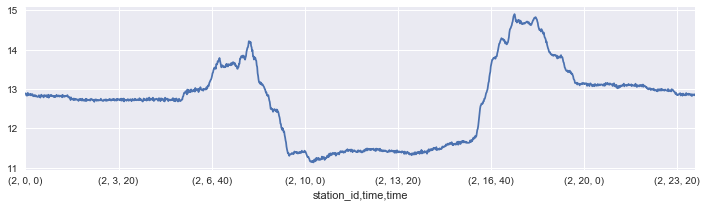

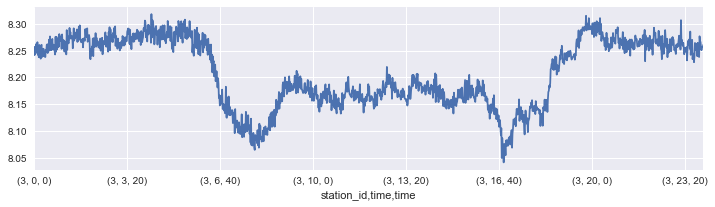

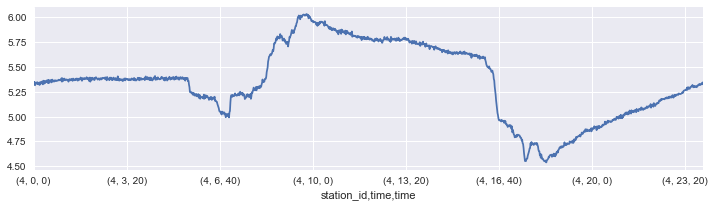

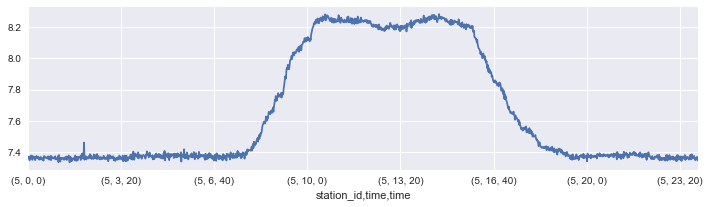

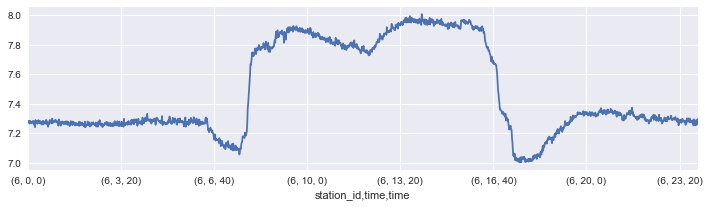

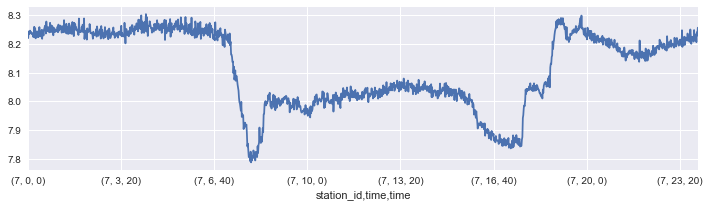

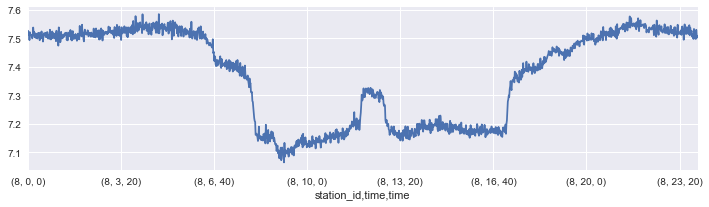

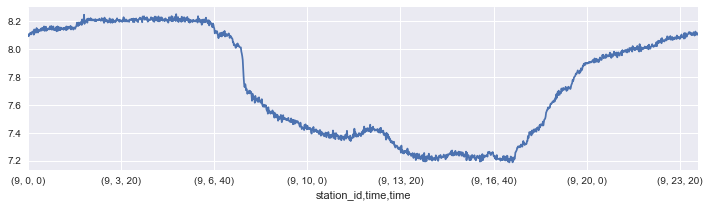

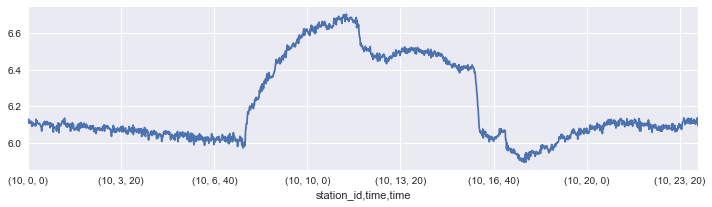

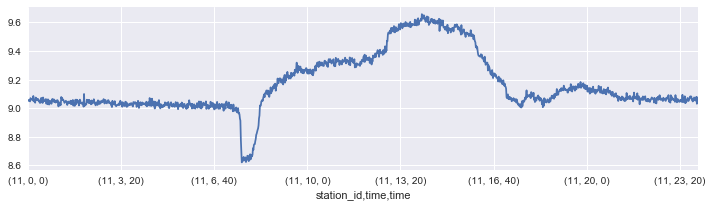

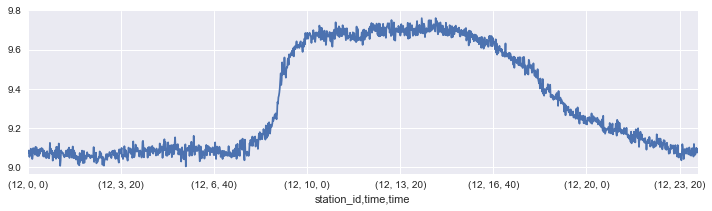

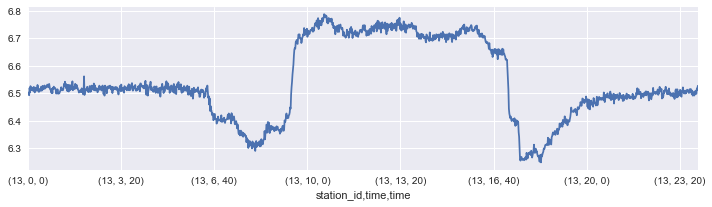

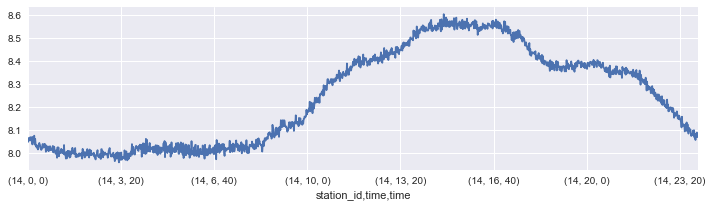

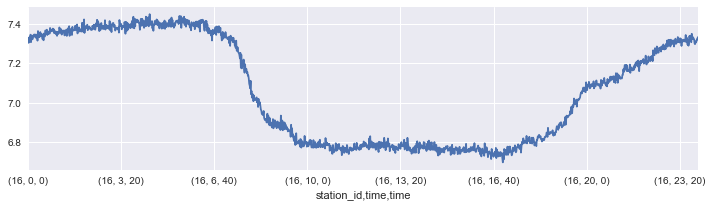

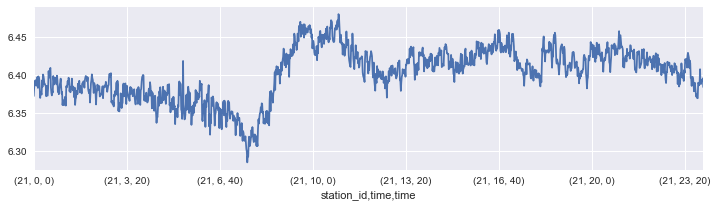

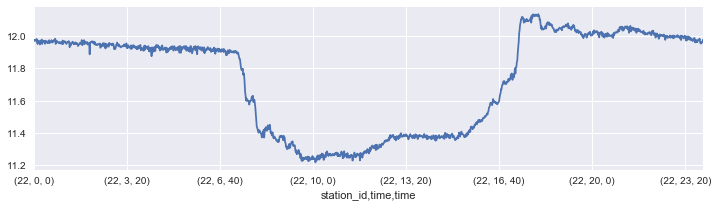

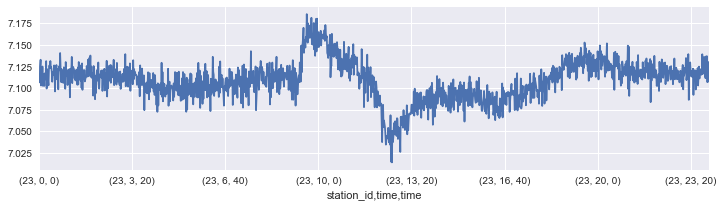

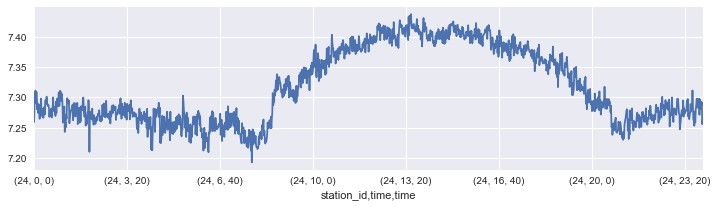

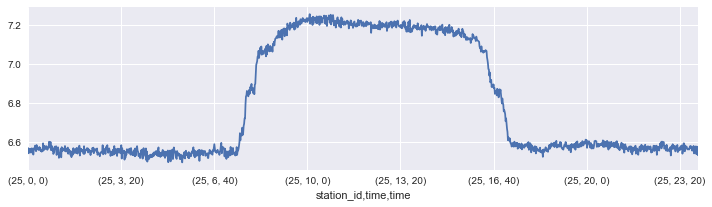

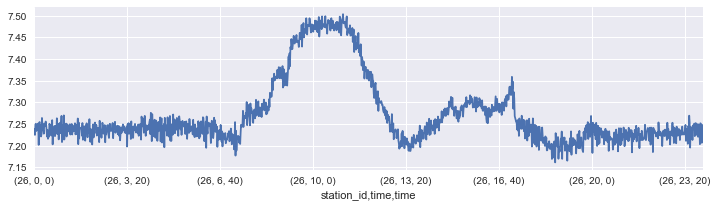

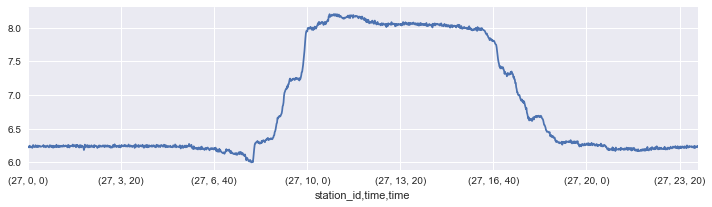

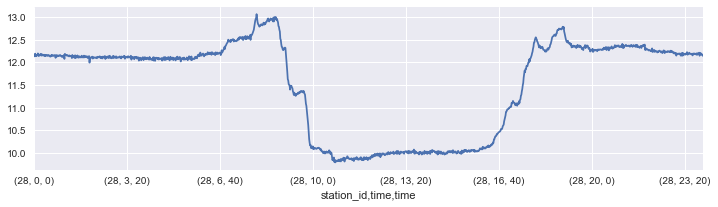

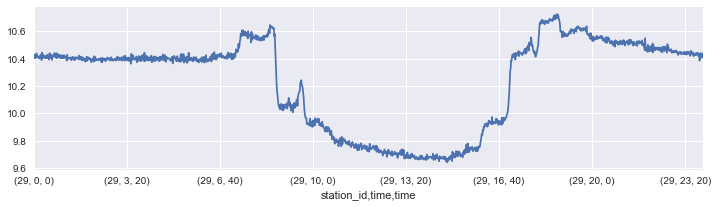

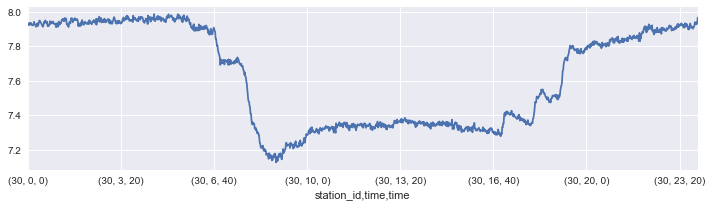

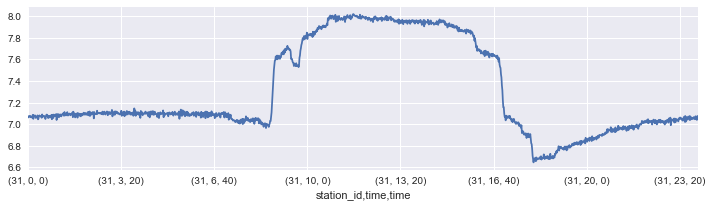

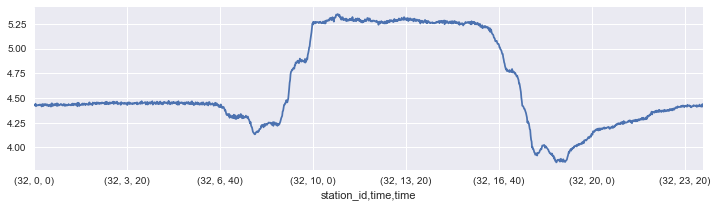

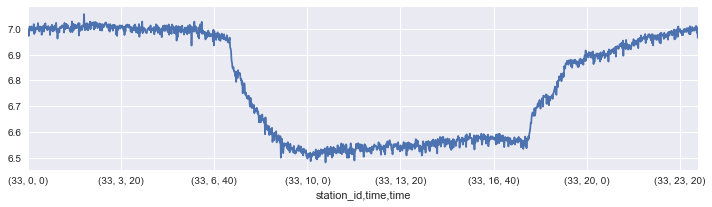

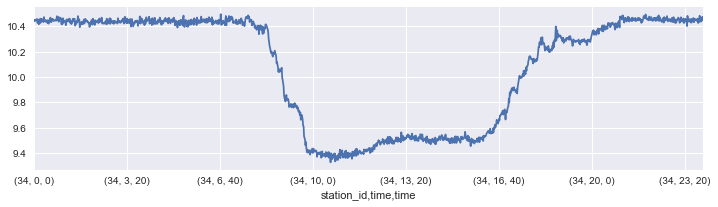

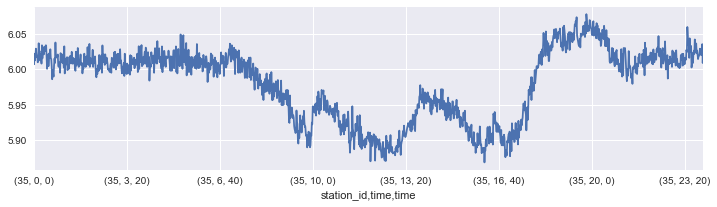

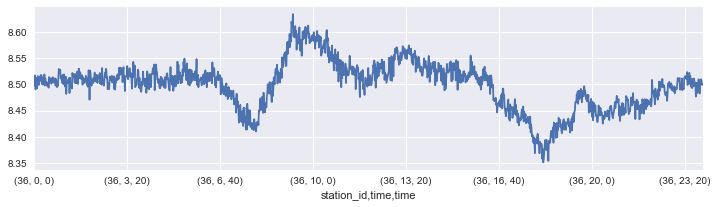

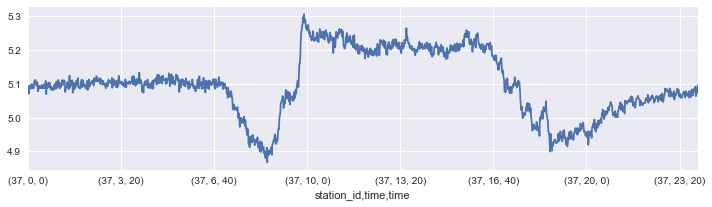

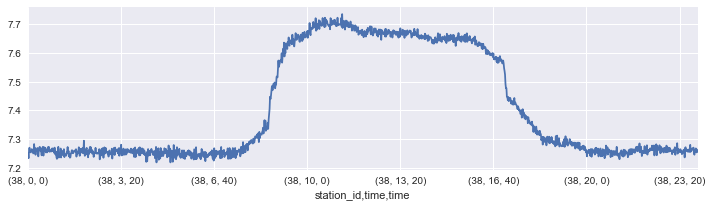

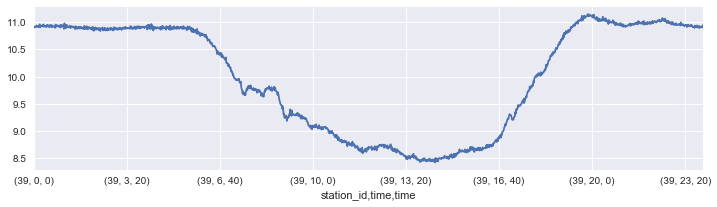

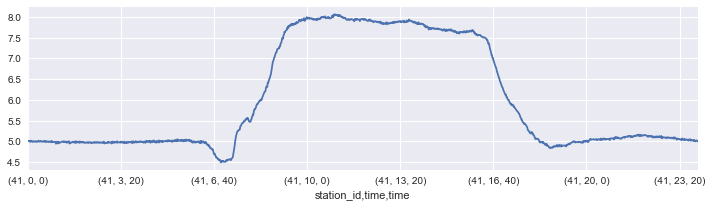

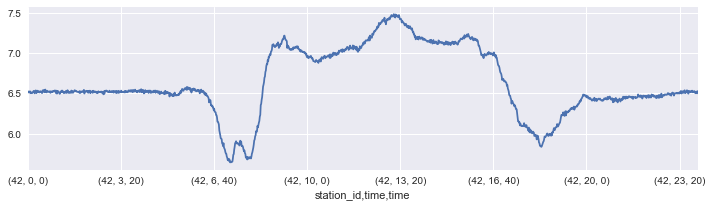

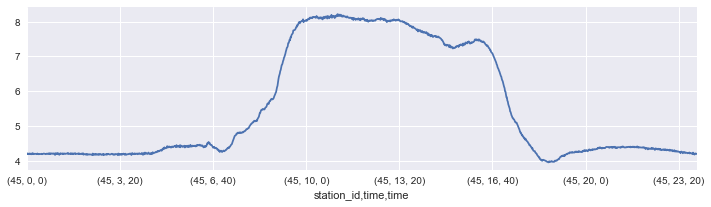

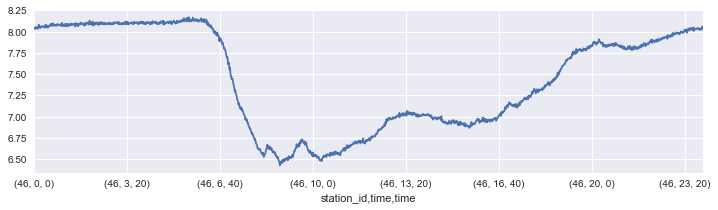

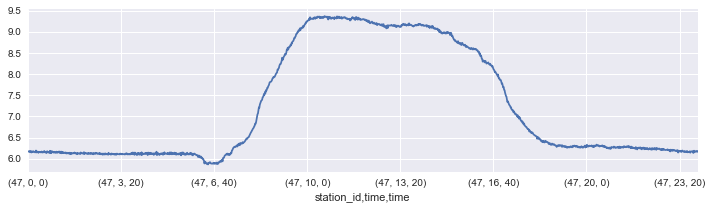

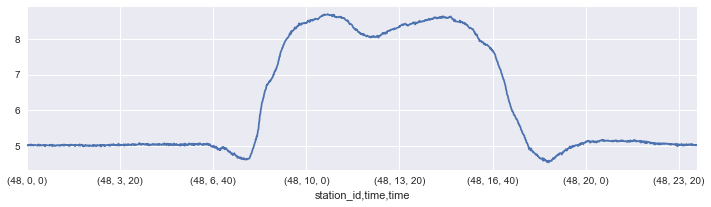

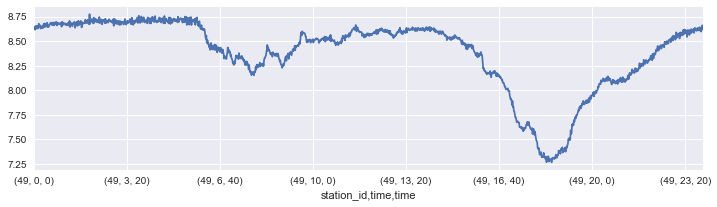

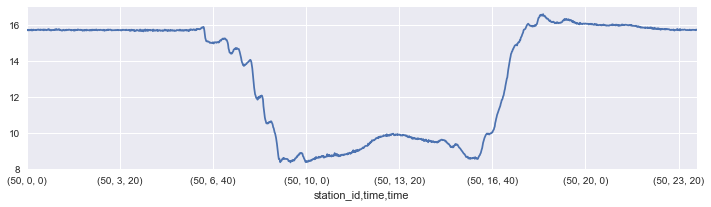

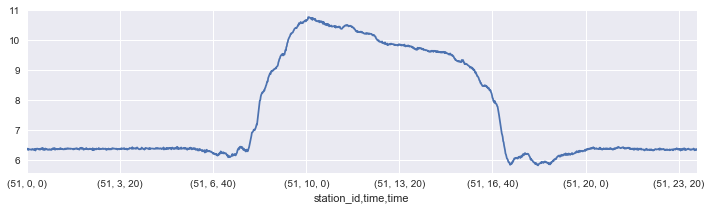

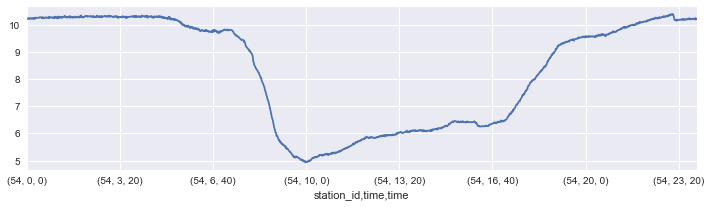

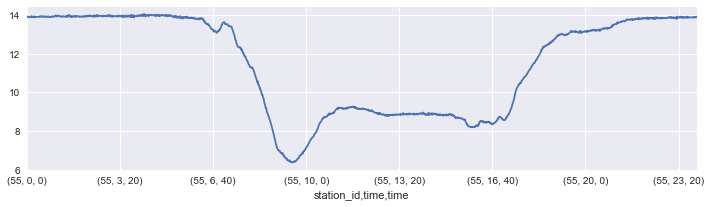

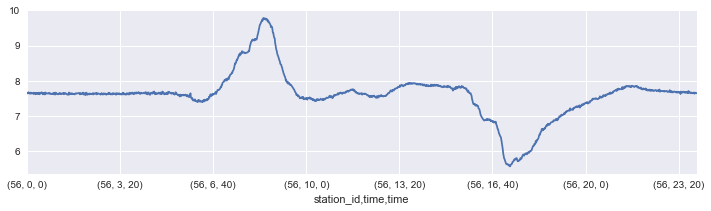

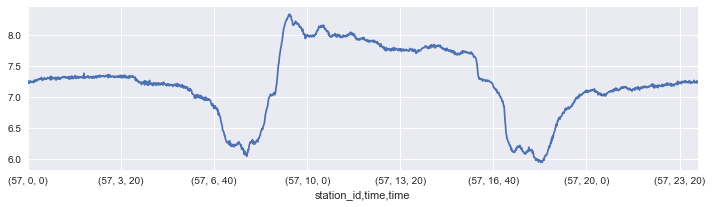

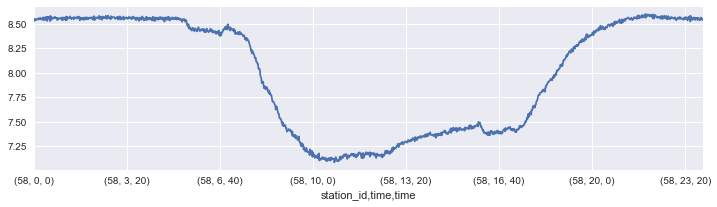

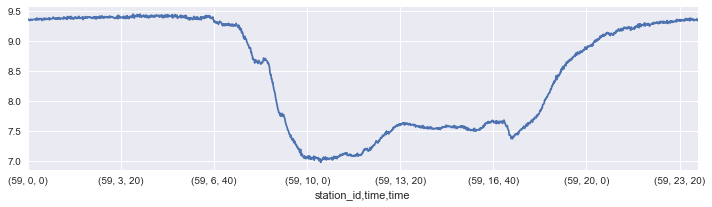

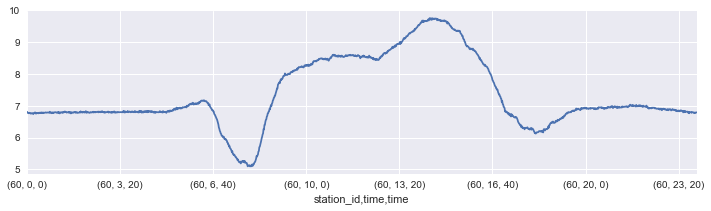

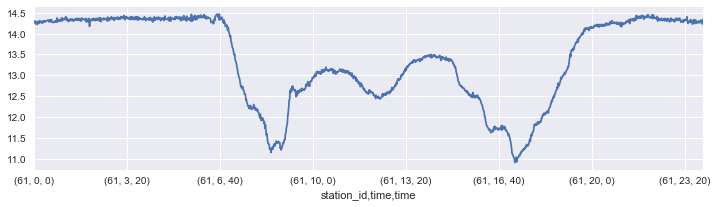

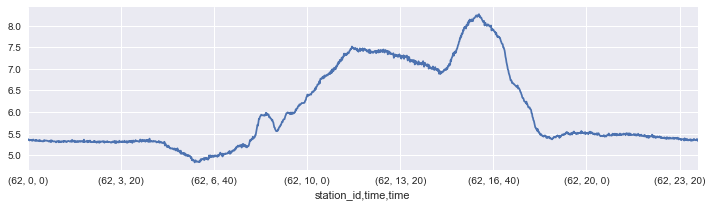

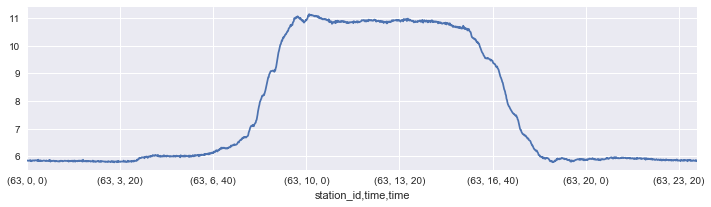

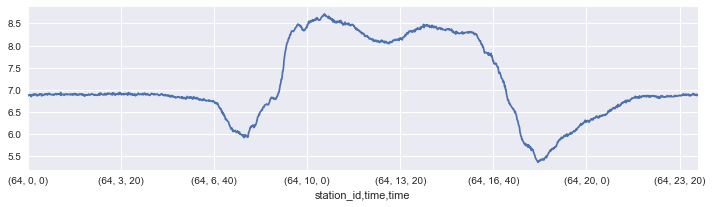

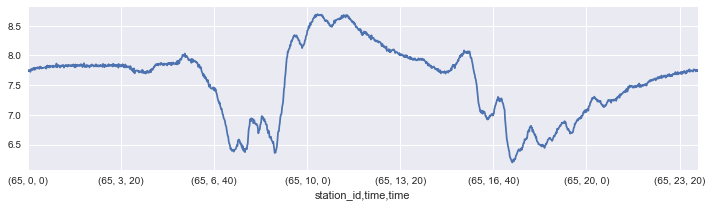

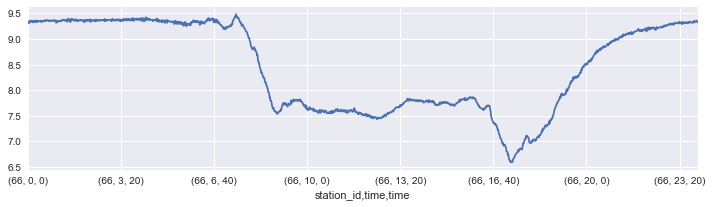

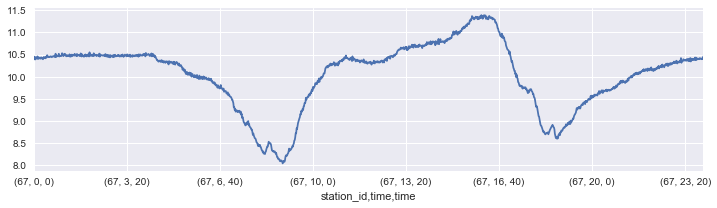

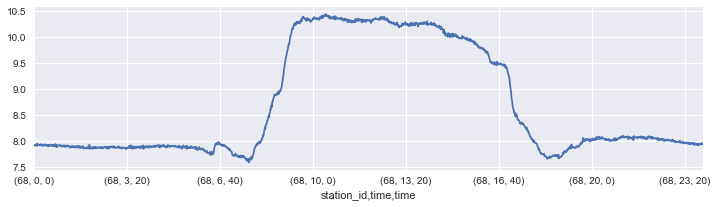

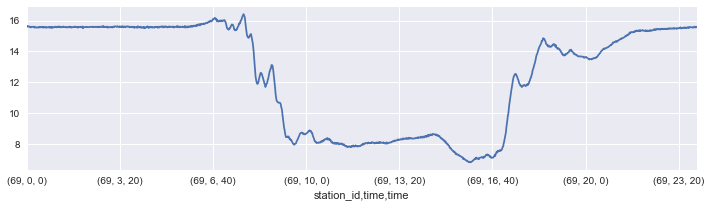

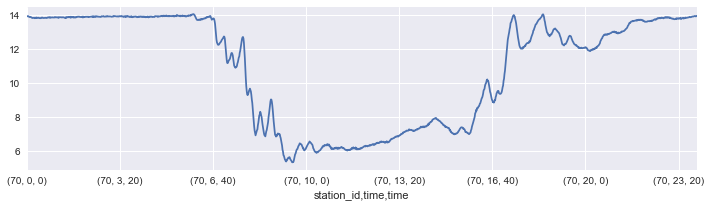

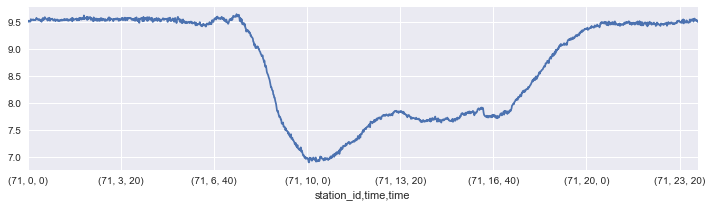

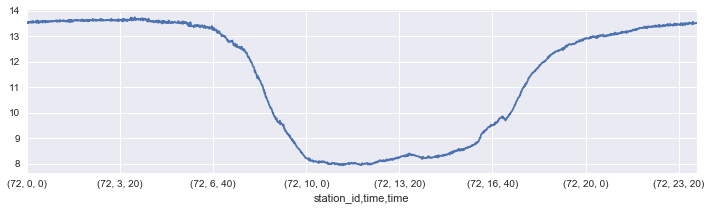

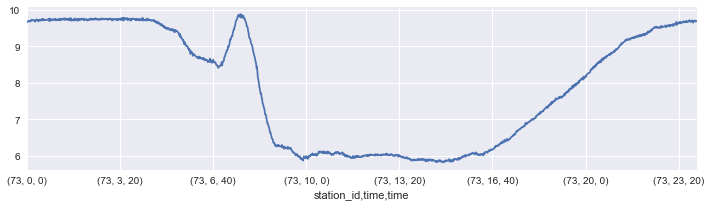

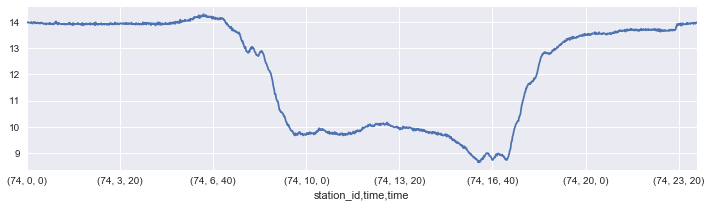

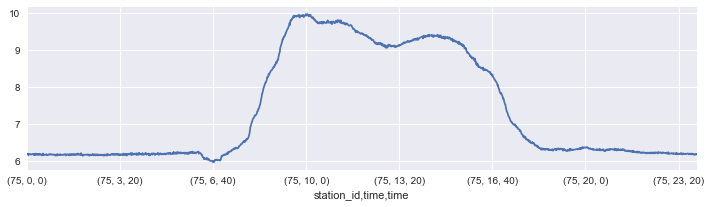

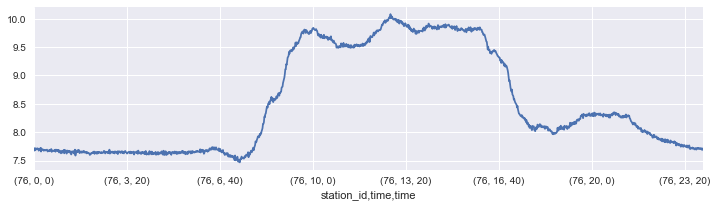

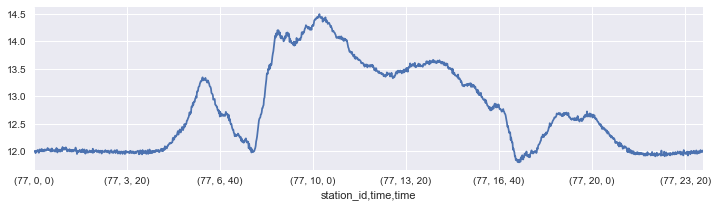

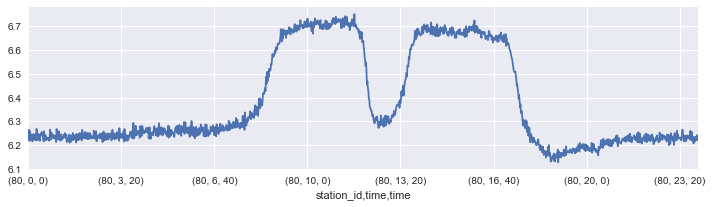

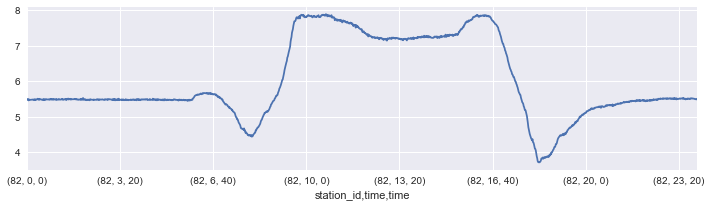

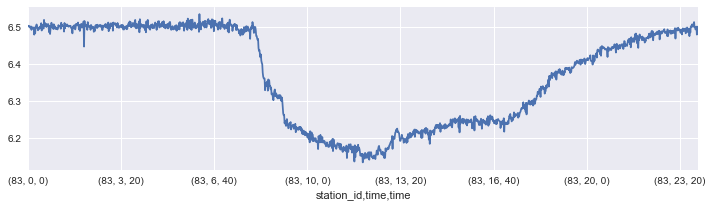

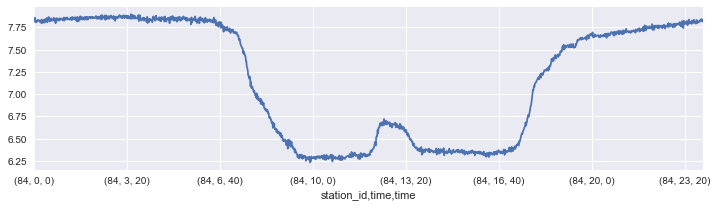

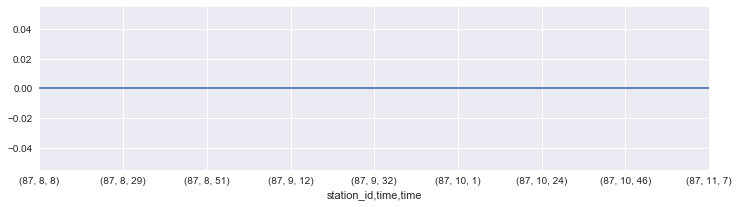

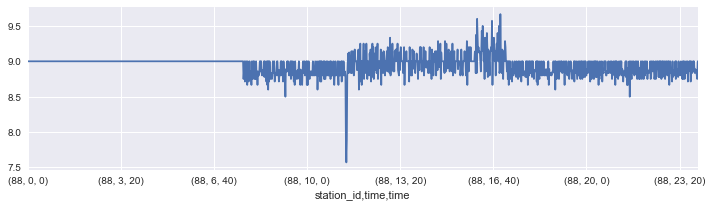

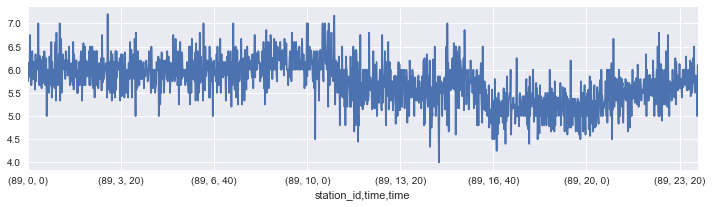

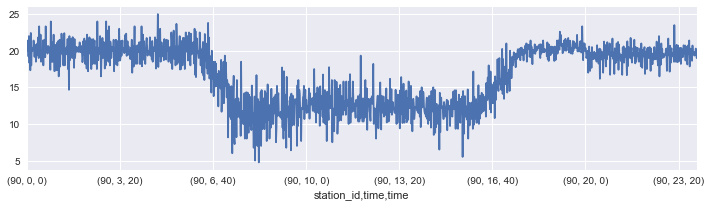

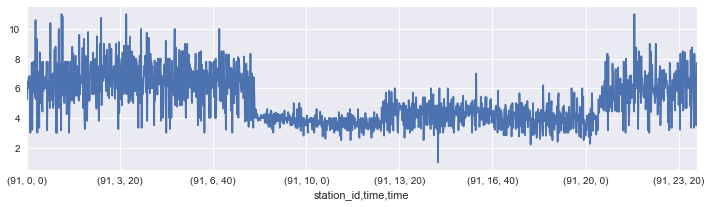

In [71]:
for i in pd.unique(status_data.station_id):
    data = status_data[status_data.station_id == i]
    data.groupby(['station_id', data.index.hour, data.index.minute]).mean()['bikes_available'].plot(figsize=(12,3))
    plt.show()

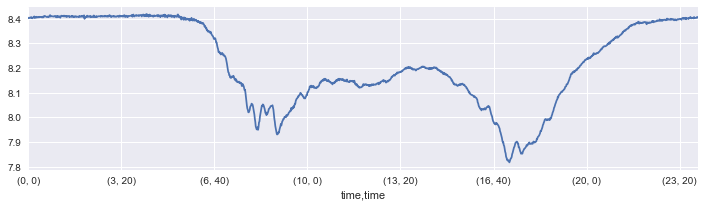

In [72]:
# for i in pd.unique(status_data.station_id):
#     data = status_data[status_data.station_id == i]
status_data.groupby([status_data.index.hour, status_data.index.minute]).mean()['bikes_available'].plot(figsize=(12,3))
plt.show()

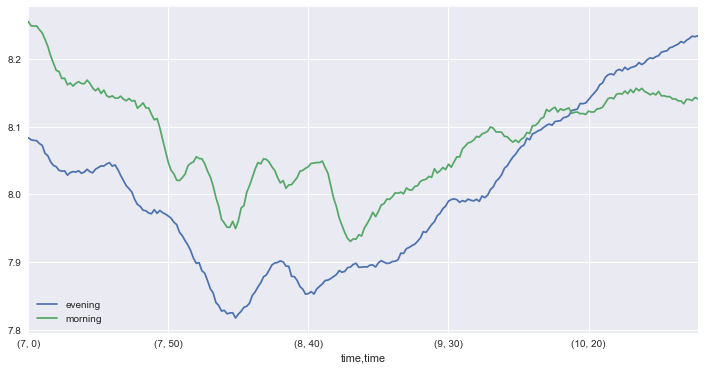

In [77]:

ax = evening_commute_status.groupby([evening_commute_status.index.hour, evening_commute_status.index.minute]).mean()['bikes_available'].plot(figsize=(12,6))
morning_commute_status.groupby([morning_commute_status.index.hour, morning_commute_status.index.minute]).mean()['bikes_available'].plot(ax=ax)
plt.legend(['evening', 'morning'],loc='best')
plt.show()

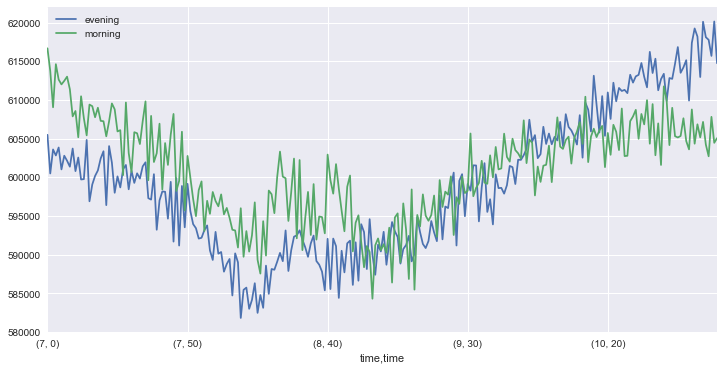

In [78]:

ax = evening_commute_status.groupby([evening_commute_status.index.hour, evening_commute_status.index.minute]).sum()['bikes_available'].plot(figsize=(12,6))
morning_commute_status.groupby([morning_commute_status.index.hour, morning_commute_status.index.minute]).sum()['bikes_available'].plot(ax=ax)
plt.legend(['evening', 'morning'],loc='best')
plt.show()

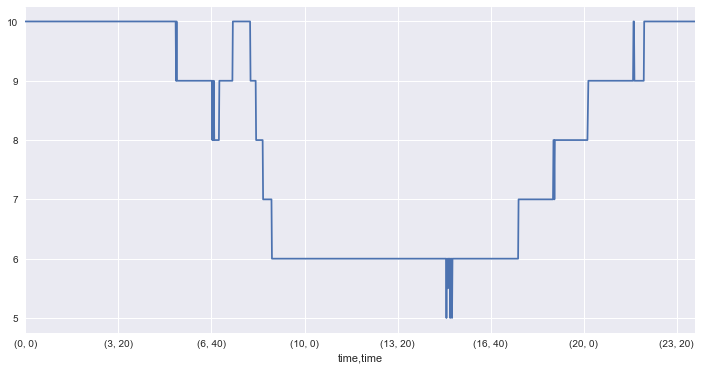

In [101]:
status_73_data = status_data[status_data.station_id == 73]

status_73_data.groupby([status_73_data.index.hour, status_73_data.index.minute]).max()['bikes_available'].plot(figsize=(12,6))
plt.show()